In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tqdm import tqdm
import warnings
from keras.layers import *
from keras import backend as keras
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_height = 256
image_width = 256
image_depth = 1
epochs=100
batch_size = 8
epoch_index = [i for i in range(1, epochs+1)]

#### Load data

In [3]:
images = np.load(os.path.join("Brain_MRI_data1", "images.npy"), allow_pickle=True)
masks = np.load(os.path.join("Brain_MRI_data1", "masks.npy"), allow_pickle=True)

#### Change all image to grey

In [4]:
image_index = 0
for image in tqdm(images):
    plt.imsave(os.path.join("Brain_MRI_Segment_image", "image_{}.jpg".format(image_index)), image, cmap='gray')
    image_index += 1

mask_index = 0
for mask in tqdm(masks):
    plt.imsave(os.path.join("Brain_MRI_Segment_mask", "mask_{}.jpg".format(mask_index)), mask, cmap='gray')
    mask_index += 1

100%|██████████| 3064/3064 [00:24<00:00, 127.58it/s]


In [14]:
image_dir_name = "Brain_MRI_Segment_image"
mask_dir_name = "Brain_MRI_Segment_mask"
image_list = list()
mask_list = list()

images_dir = sorted(os.listdir(image_dir_name))
for image in tqdm(images_dir):
    current_image = cv2.imread(os.path.join(image_dir_name, image))
    current_image = cv2.resize(current_image, (image_height, image_width)).astype("float32")
    current_image -= current_image.mean()
    current_image /= current_image.std()
    current_image_180 = cv2.rotate(current_image, cv2.ROTATE_180)
    current_image_r90 = cv2.rotate(current_image, cv2.ROTATE_90_CLOCKWISE)
    current_image_l90 = cv2.rotate(current_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    image_list.append(current_image)
    image_list.append(current_image_180)
    image_list.append(current_image_r90)
    image_list.append(current_image_l90)



masks_dir = sorted(os.listdir(mask_dir_name))
for mask in tqdm(masks_dir):
    current_mask = cv2.imread(os.path.join(mask_dir_name, mask), cv2.IMREAD_GRAYSCALE)
    current_mask = cv2.resize(current_mask, (image_height, image_width)).astype("float32")
    current_mask -= current_mask.mean()
    current_mask /= current_mask.std()
    current_mask_180 = cv2.rotate(current_mask, cv2.ROTATE_180)
    current_mask_r90 = cv2.rotate(current_mask, cv2.ROTATE_90_CLOCKWISE)
    current_mask_l90 = cv2.rotate(current_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
    mask_list.append(current_mask)
    mask_list.append(current_mask_180)
    mask_list.append(current_mask_r90)
    mask_list.append(current_mask_l90)


features = np.array(image_list)
masks = np.array(mask_list)
# masks = (masks > 0).astype(int)
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))

100%|██████████| 3064/3064 [00:01<00:00, 1564.66it/s]


In [16]:
print("image dimension: {}, label dimension: {}".format(features.shape, masks.shape))

image dimension: (12256, 256, 256, 3), label dimension: (12256, 256, 256, 1)


#### Train, Test, Validation Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, masks, test_size=0.25, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)
# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')
# y_val = y_val.astype("float32")

In [18]:
# Save model function
def save_model_unet(model_name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                                    monitor='val_iou',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='max')
    return [checkpoint]

#### Define ResxUnet

In [20]:
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input

    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])

    return merge

def ResXUnet(input_shape=(256, 256, 3)):
    X_input = Input(input_shape) #iniating tensor of input shape

    # Stage 1
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPool2D((2,2))(conv_1)

    # stage 2
    conv_2 = resblock(pool_1, 32)
    pool_2 = MaxPool2D((2,2))(conv_2)

    # Stage 3
    conv_3 = resblock(pool_2, 64)
    pool_3 = MaxPool2D((2,2))(conv_3)

    # Stage 4
    conv_4 = resblock(pool_3, 128)
    pool_4 = MaxPool2D((2,2))(conv_4)

    # Stage 5 (bottle neck)
    conv_5 = resblock(pool_4, 256)

    # Upsample Stage 1
    up_1 = upsample_concat(conv_5, conv_4)
    up_1 = resblock(up_1, 128)

    # Upsample Stage 2
    up_2 = upsample_concat(up_1, conv_3)
    up_2 = resblock(up_2, 64)

    # Upsample Stage 3
    up_3 = upsample_concat(up_2, conv_2)
    up_3 = resblock(up_3, 32)

    # Upsample Stage 4
    up_4 = upsample_concat(up_3, conv_1)
    up_4 = resblock(up_4, 16)

    # final output
    out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)
    return Model(X_input, out)

#### Loss Function for ResXUnet

In [21]:
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

#### early stop, decay learning rate, check_point

In [23]:
def save_model_resxunet(model_name):
    checkpoint = ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                                    verbose=1,
                                                    save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  mode='min',
                                  verbose=1,
                                  patience=10,
                                  min_delta=0.0001,
                                  factor=0.2
                                 )
    return [checkpoint, earlystopping, reduce_lr]

#### Define U-Net Model and Loss Function

In [24]:
smooth =100
def iou(y_true, y_pred):
    intersection = keras.sum(y_true * y_pred)
    sum_ = keras.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)


    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = Model(inputs=[inputs] , outputs = [conv10])
    return model

In [11]:
unet_path = "unet.hdf5"
model_Unet = unet(input_size=(image_height,image_width,1))
model_Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False),
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
model_Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
unet_history = model_Unet.fit(x=X_train,y=y_train, epochs=epochs, verbose=1, batch_size=8, validation_data=(X_val, y_val), callbacks=save_model_unet(unet_path))

Epoch 1/100
862/862 [==============================] - 169s 178ms/step - loss: 0.9368 - binary_accuracy: 0.8161 - iou: 0.0330 - dice_coef: 0.0632 - val_loss: 0.9270 - val_binary_accuracy: 0.9078 - val_iou: 0.0383 - val_dice_coef: 0.0730

Epoch 00001: val_iou improved from -inf to 0.03832, saving model to trained_model_weights\unet.hdf5
Epoch 2/100
862/862 [==============================] - 149s 173ms/step - loss: 0.8695 - binary_accuracy: 0.9458 - iou: 0.0709 - dice_coef: 0.1305 - val_loss: 0.8681 - val_binary_accuracy: 0.8682 - val_iou: 0.0715 - val_dice_coef: 0.1320

Epoch 00002: val_iou improved from 0.03832 to 0.07147, saving model to trained_model_weights\unet.hdf5
Epoch 3/100
862/862 [==============================] - 148s 172ms/step - loss: 0.7406 - binary_accuracy: 0.9718 - iou: 0.1519 - dice_coef: 0.2594 - val_loss: 0.6894 - val_binary_accuracy: 0.9768 - val_iou: 0.1875 - val_dice_coef: 0.3103

Epoch 00003: val_iou improved from 0.07147 to 0.18747, saving model to trained_mode

Text(0.5, 1.0, 'Unet for segmentation')

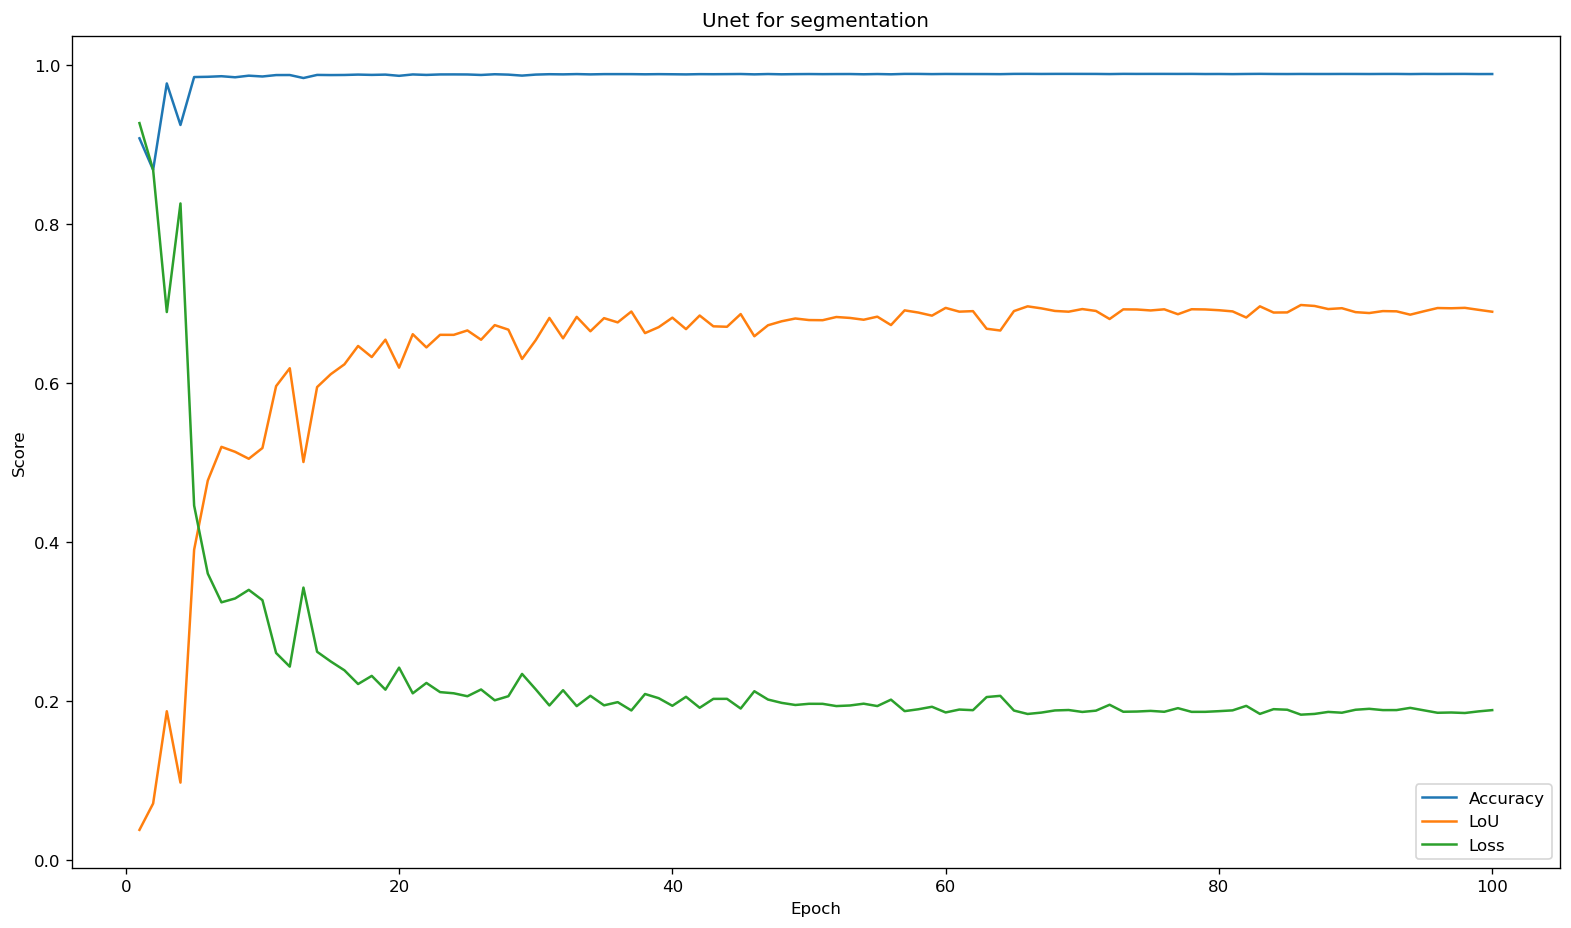

In [13]:
model_Unet_result = pd.DataFrame({"Accuracy": unet_history.history["val_binary_accuracy"],
                                  "LoU": unet_history.history["val_iou"],
                                  "Loss": unet_history.history["val_loss"]}, index=epoch_index)
model_Unet_result.to_csv("Unet_result.csv")
ax_unet = model_Unet_result.plot.line(figsize=(16, 9))
ax_unet.set_xlabel("Epoch")
ax_unet.set_ylabel("Score")
ax_unet.set_title("Unet for segmentation")

In [14]:
model_Unet.load_weights(os.path.join("trained_model_weights", unet_path))
model_Unet.evaluate(x=X_test, y=y_test)

In [15]:
model_Unet.predict(x=X_test)

KeyboardInterrupt: 

#### Train ResXUnet

In [27]:
res_unet_path = "res_unet.hdf5"
model_res_unet = ResXUnet((256, 256, 3))
model_res_unet.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1),
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
model_res_unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_78 (BatchN  (None, 256, 256, 16  64         ['conv2d_81[0][0]']              
 ormalization)                  )                                                           

In [28]:
model_res_unet_history = model_res_unet.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=save_model_resxunet(res_unet_path))

Epoch 1/100


2023-02-24 15:57:58.521914: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 15:58:00.932038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  9/216 [>.............................] - ETA: 2:55 - loss: 0.9719 - tversky: 0.0372

KeyboardInterrupt: 

In [16]:
test = X_test[4]
test = np.reshape(test, (1, 256, 256, 1))
truth = y_test[4]
truth = np.reshape(truth, (1, 256, 256, 1))

In [17]:
predicted = model_Unet.predict(x=test)

In [18]:
model_Unet.evaluate(x=predicted, y=truth)

1/1 [==============================] - 0s 23ms/step - loss: 0.0533 - binary_accuracy: 0.9885 - iou: 0.9017 - dice_coef: 0.9467


[0.05332601070404053, 0.988525390625, 0.9016579389572144, 0.9466739892959595]

In [19]:
predicted = predicted.reshape(256, 256, 1)

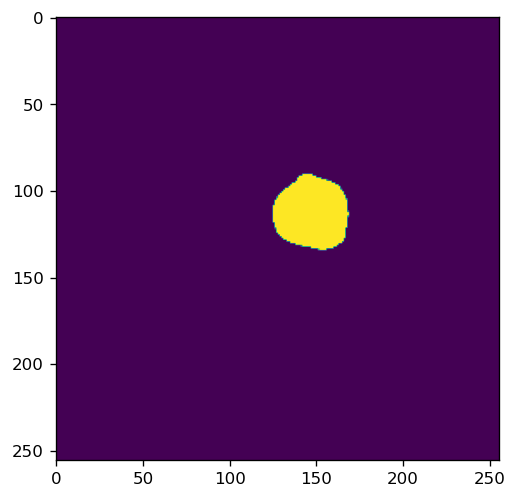

In [20]:
plt.imshow(predicted)

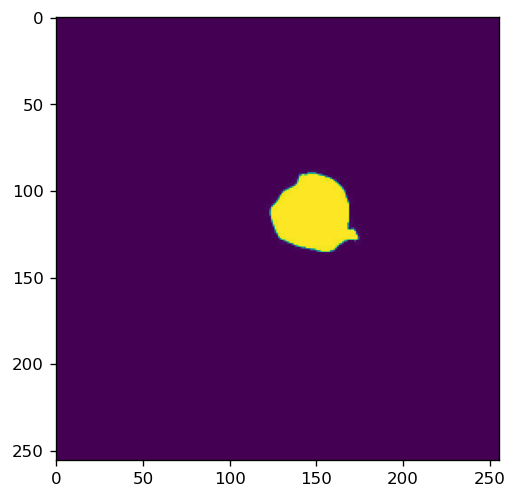

In [21]:
plt.imshow(y_test[4])

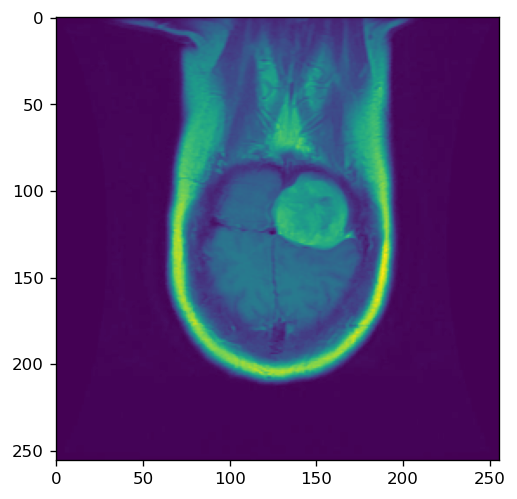

In [22]:
plt.imshow(X_test[4])